# Corpus Analysis




In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

In [0]:
#!pip install --upgrade git+https://github.com/zalandoresearch/flair --quiet
!pip install flair==0.4.3 --quiet

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from tqdm import tqdm
from typing import List, Union
from flair.datasets import ColumnCorpus, ClassificationCorpus, CSVClassificationCorpus
from flair.data import Corpus, Sentence
from flair.visual.ner_html import render_ner_html
from IPython.core.display import display, HTML
from wordcloud import WordCloud
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import pandas as pd
import json
from pathlib import Path

plt.rc('axes', axisbelow=True)



class CorpusAnalysis():
    def __init__(
        self,
        path: Union[Path, str],
        corpus: Corpus,
    ):
        if isinstance(path, str):
            path = Path(path)
        assert path.exists()
        
        self.path = path
        self.corpus = corpus
        self.sentences = self.corpus.get_all_sentences()
        print(self.corpus)
        
    
    def obtain_statistics(
        self,
        tag_type: str = 'ner',
        save_as_json: bool = True
    ):
        stats_splits = self.corpus.obtain_statistics(tag_type)
        stats_complete = json.dumps(Corpus._obtain_statistics_for(self.sentences,'complete', tag_type), indent=4)
        if save_as_json:
            (self.path/'stats_splits.json').write_text(stats_splits)
            (self.path/'stats_complete.json').write_text(stats_complete)
        
        return (stats_splits, stats_complete)
        
        
    def most_common_tokens(
        self,
        nr_tokens: int = 15,
        min_freq: int = 5,
        stop_words = []
    ):
        # get most common tokens
        top = self.corpus._get_most_common_tokens(max_tokens=-1, min_freq=min_freq)
        top_filtered = [t for t in top if t.lower() not in stop_words and len(t)>1][:nr_tokens]

        return top_filtered
    
    
    def wordcloud(
        self,
        figsize = ((10,10)),
        savefig_file = None,
        **kwargs
    ):
        text = (' ').join([s.to_plain_string() for s in self.sentences])
        # Create and generate a word cloud image:
        wordcloud = WordCloud(**kwargs).generate(text)
        # Display the generated image:
        plt.figure(figsize=figsize)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        if savefig_file:
            plt.savefig(self.path/savefig_file, dpi=300)
        plt.show()
    
    
    
class ColumnCorpusAnalysis(CorpusAnalysis):
    def __init__(
        self,
        path: Union[Path, str],
        columns: dict = None,
        tag_types: List = ['ner'],
        corpus: Corpus = None
    ):
        if isinstance(path, str):
            path = Path(path)
        assert path.exists()
        
        self.path = path
        if corpus:
            self.corpus = corpus
        else:
            self.corpus = ColumnCorpus(self.path, columns)
        self.sentences = ColumnCorpusAnalysis.index_spans(self.corpus.get_all_sentences(), tag_types)
        print(self.corpus)
        
    
    def visualize_ner_tags(
        self,
        display_index = range(5),
        save_display_html: bool = False,
        save_all_html: bool = True,
        **kwargs
    ):
        html = render_ner_html([self.sentences[i] for i in display_index], **kwargs)
        display(HTML(html))
        if save_display_html:
            (self.path/'sentences_true_example.html').write_text(html)
        if save_all_html:
            html = render_ner_html(self.sentences, **kwargs)
            (self.path/'sentences_true_all.html').write_text(html)
    
    
    def tag_distribution(
        self,
        nr_tags: int = 10,
        tag_type: str = 'ner',
        savefig_file = None,
        **kwargs
    ):
        support = defaultdict(int)
        for sentence in self.sentences:
            true_tags = [tag.tag for tag in sentence.get_spans(tag_type)]
            for tag in true_tags:
                support[tag] +=1
        support = pd.DataFrame.from_dict(support, orient='index',columns=['support']).sort_values('support', ascending=False)
        html_table = support.to_html()

        #(self.path/'support.html').write_text(html_table)
        
        support_top = support[:nr_tags].copy()
        if nr_tags < len(support):
            support_top.loc['others'] = support[nr_tags:].sum()
        # pie plot support
        support_top.plot.pie(y='support', **kwargs)
        plt.legend(labels=support_top.index, bbox_to_anchor=(1, 0, 0.1, 1), loc='center right')
        plt.tight_layout()
        if savefig_file:
            plt.savefig(self.path/savefig_file, dpi=600)
        plt.show()
        
    
    def most_common_tokens_per_tags(
        self,
        tag_type: str = 'ner',
        max_tokens: int = None,
        convert_to_lower: bool = True,
        print_without_count: bool = False
    ):
        mc_tokens={}
        for sentence in self.sentences:
            tag_tuples = [(tag.tag, tag.text) for tag in sentence.get_spans(tag_type)]
            for tag, text in tag_tuples:
                if tag not in mc_tokens.keys():
                    mc_tokens[tag] = defaultdict(int)
                if convert_to_lower:
                    mc_tokens[tag][text.lower()] +=1
                else:
                    mc_tokens[tag][text] +=1

        for key, value in mc_tokens.items():
            mc_tokens[key] = Counter(value).most_common(max_tokens)
            
        # nice printing
        for key, value in mc_tokens.items():
            if print_without_count:
                value = [tokens for (tokens, counts) in value]
            print('{:<20}{}'.format(str(key),str(value)))
            
    @staticmethod        
    def index_spans(sentences, tag_types):
        untagged = [Sentence(s.to_original_text()) for s in sentences]
        for i in range(len(untagged)):
            tokens = sentences[i].tokens
            for j, token in enumerate(tokens):
                for tag_type in tag_types:
                    label = token.get_tag(tag_type)
                    untagged[i].tokens[j].add_tag_label(tag_type, label)
        return untagged

    

class ClassificationCorpusAnalysis(CorpusAnalysis):
    def __init__(
        self,
        path: Union[Path, str],
        column_name_map: dict = None,
        corpus: Corpus = None,
        **corpus_params
    ):
        if isinstance(path, str):
            path = Path(path)
        assert path.exists()
        
        self.path = path
        if corpus:
            self.corpus = corpus
        else:
            if column_name_map:
                self.corpus = CSVClassificationCorpus(self.path, column_name_map, **corpus_params)
            else:
                self.corpus = ClassificationCorpus(self.path, **corpus_params)
        self.sentences = self.corpus.get_all_sentences()
        print(self.corpus)
        
    
    def class_distribution(
        self,
        multiclass: bool = False,
        nr_classes: int = 10,
        savefig_file = None,
        **kwargs
    ):
        class_count = Corpus._get_class_to_count(self.sentences)
        class_count = pd.DataFrame.from_dict(class_count, orient='index',columns=['count']).sort_values('count', ascending=False)
        html_table = class_count.to_html()
        
        # plot distribution
        class_count_top = class_count[:nr_classes].copy()
        if not multiclass:
            if nr_classes < len(class_count):
                class_count_top.loc['others'] = class_count[nr_classes:].sum()
            # pie plot class_count
            class_count_top.plot.pie(y='count', **kwargs)
            plt.legend(labels=class_count_top.index, bbox_to_anchor=(1, 0, 0.1, 1), loc='center right')
        else:
            class_count_top.plot.bar(y='count', **kwargs)
            plt.gca().yaxis.grid(True, linestyle='--')
            
        plt.tight_layout()
        if savefig_file:
            plt.savefig(self.path/savefig_file, dpi=600)
        plt.show()
        
    
    def example_document_for_classes(
        self,
    ):
        # Todo!
        pass

    
    
class TextAnalysis():
    def __init__(
        self,
        path: Union[Path, str]
    ):
        if isinstance(path, str):
            path = Path(path)
        assert path.exists()
        
        self.path = path
        self.token_counter = defaultdict(int)
        tokens_in_line = []
        with self.path.open(mode='r') as textfile:
            for i, line in enumerate(tqdm(textfile)):
                tokens = line.split()
                tokens_in_line.append(len(tokens))
                for token in tokens:
                    self.token_counter[token] += 1

        self.token_counter = Counter(self.token_counter)
        self.statistics = {
            "file_name": self.path.name,
            "total_number_of_lines": len(tokens_in_line),
            "number_of_tokens": {
                "total": sum(tokens_in_line),
                "max": max(tokens_in_line),
                "min": min(tokens_in_line),
                "avg": sum(tokens_in_line)/len(tokens_in_line)
            }  
        }
        
    
    def obtain_statistics(
        self,
        save_as_json: bool = True
    ):
        stats = json.dumps(self.statistics, indent=4)
        if save_as_json:
            (self.path.parent/'stats.json').write_text(stats)
        
        return stats
        
    
    def most_common_tokens(
        self,
        nr_tokens: int = 15,
        min_freq: int = 5,
        stop_words = [],
        without_count: bool = True
    ):
        # get most common tokens
        if stop_words:
            mct = TextAnalysis._filter_token_counter(self.token_counter, stop_words).most_common(nr_tokens)
        else:
            mct = self.token_counter.most_common(nr_tokens)
        if without_count:
            mct = [token for (token, count) in mct]
            
        return mct
        
        
    def wordcloud(
        self,
        figsize = ((10,10)),
        stop_words = [],
        savefig_file = None,
        **kwargs
    ):
        if stop_words:
            counter = TextAnalysis._filter_token_counter(self.token_counter, stop_words)
        else:
            counter = self.token_counter
        
        # Create and generate a word cloud image:
        wordcloud = WordCloud(**kwargs).generate_from_frequencies(counter)
        # Display the generated image:
        plt.figure(figsize=figsize)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        if savefig_file:
            plt.savefig(self.path.parent/savefig_file, dpi=600)
        plt.show()
        
    
    @staticmethod    
    def _filter_token_counter(
        counter: Counter,
        stop_words: list
    ):
        counter_filter  = counter.copy()
        for t,f in counter.items():
            if t.lower() in stop_words or len(t)<=1:
                del counter_filter[t]
            
        return counter_filter

    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# PATHS
from pathlib import Path
corpus_path = Path('/gdrive/My Drive/embeddings-comparison/resources/corpora')

corpus_path_ner = corpus_path/'column_corpora'
corpus_path_text = corpus_path/'text_corpora'
corpus_path_int = corpus_path/'classification_corpora'

## Testing ColumnCorpusAnalysis

In [0]:
columns = {0: 'text', 1: 'ner'}
corpus_folder = corpus_path_ner/'tagged'
cca = ColumnCorpusAnalysis(path=corpus_folder, columns=columns, tag_types=['ner'])

#from flair.datasets import WIKINER_GERMAN
#corpus: Corpus = WIKINER_GERMAN().downsample(0.1)
#cca = ColumnCorpusAnalysis(path=corpus_path/'wiki_ner_test', corpus=corpus, tag_types=['ner','pos'])


2019-11-13 19:02:37,606 Reading data from /gdrive/My Drive/embeddings-comparison/resources/corpora/column_corpora/tagged
2019-11-13 19:02:37,607 Train: /gdrive/My Drive/embeddings-comparison/resources/corpora/column_corpora/tagged/train.txt
2019-11-13 19:02:37,608 Dev: /gdrive/My Drive/embeddings-comparison/resources/corpora/column_corpora/tagged/dev.txt
2019-11-13 19:02:37,609 Test: /gdrive/My Drive/embeddings-comparison/resources/corpora/column_corpora/tagged/test.txt
Corpus: 698 train + 150 dev + 150 test sentences


In [0]:
print(cca.obtain_statistics(tag_type='ner')[1])

{
    "dataset": "complete",
    "total_number_of_documents": 998,
    "number_of_documents_per_class": {},
    "number_of_tokens_per_tag": {
        "O": 17740,
        "B-media-receiver": 165,
        "B-brand": 260,
        "B-conjunction": 1775,
        "B-router": 933,
        "B-negation": 1200,
        "B-metadata": 539,
        "I-conjunction": 17,
        "B-connection": 853,
        "B-device": 880,
        "B-modifier": 61,
        "B-failure": 388,
        "B-equal": 101,
        "B-quantity": 330,
        "B-unit": 321,
        "B-service": 418,
        "I-failure": 30,
        "B-solution": 101,
        "I-solution": 11,
        "B-color": 101,
        "I-unit": 569,
        "I-router": 395,
        "I-media-receiver": 118,
        "I-device": 120,
        "B-greater": 56,
        "B-operating-system": 67,
        "B-panel-type": 19,
        "I-service": 280,
        "B-cause-of-failure": 21,
        "B-less": 80,
        "I-brand": 1,
        "I-metadata": 6,
        "B-

In [0]:
print(cca.most_common_tokens(nr_tokens=20, stop_words=stopwords.words('german')))

['Router', 'Verbindung', 'Speedport', 'WLAN', 'Telefon', 'Problem', 'Handy', 'Probleme', 'DSL', 'LTE', 'Hybrid', 'TV', 'Samsung', 'Internet', 'LAN', 'mehr', 'Tarif', 'Hallo', 'per', 'MR']


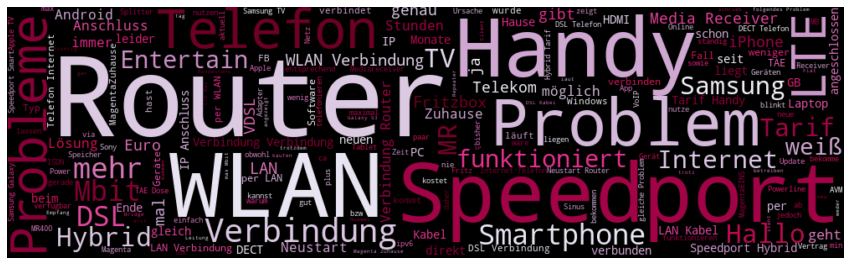

In [0]:
cca.wordcloud(savefig_file=None, colormap='PuRd', figsize = ((15,15)), width=1000, height=300, stopwords=stopwords.words('german'))

In [0]:
colors = {'conjunction': '#FFFF30', 'negation': '#FD5D7E', 'router': '#05FAAC', 'device': '#00BFD0', 'connection': '#FFC530', 'metadata': '#FC6DEA', 'unit': '#E8EBE7', 'service': '#DCFDEE', 'failure': '#FF1400', 'quantity': '#9ADD23', 'brand': '#B751FC', 'media-receiver': '#FF9330', 'solution': '#40FF30', 'color': '#05ACFA', 'equal': '#B2AFF8', 'less': '#56B89C', 'operating-system': '#DD5F23', 'modifier': '#008FFF', 'greater': '#F8E4AF', 'router-state': '#DEF8AF', 'cause-of-failure': '#D89EAA', 'panel-type': '#629C0B', 'wifi-encryption_2': '#4FEAF8', 'display-resolution': '#9AFA7B'}

cca.visualize_ner_tags(display_index=range(5), save_display_html=False, save_all_html=False, colors=colors)

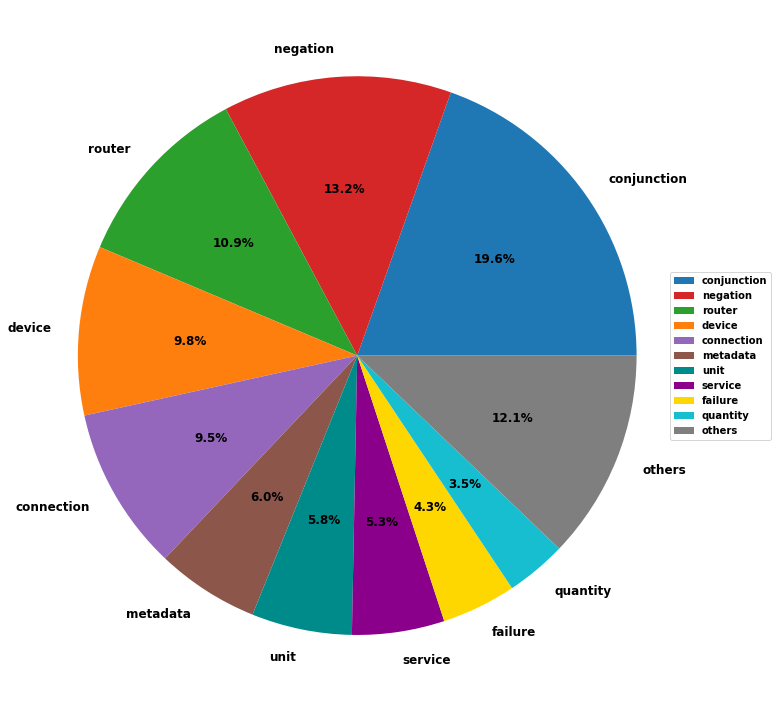

In [0]:
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'bold'
cca.tag_distribution(savefig_file = 'support_bold.png', tag_type='ner', figsize=(13, 10),autopct='%1.1f%%', label='', fontsize=12, colors=['tab:blue','tab:red','tab:green','tab:orange','tab:purple','tab:brown','darkcyan','darkmagenta','gold','tab:cyan','tab:gray'])

In [0]:
cca.most_common_tokens_per_tags(max_tokens=10, tag_type='ner', print_without_count=True)

media-receiver      ['mr', 'media receiver', 'mr400', 'mr 303', 'mediareceiver', 'mr 400', 'media-receiver', 'media receiver 400', 'mr 300', 'media receiver 300']
brand               ['samsung', 'telekom', 'apple', 'sony', 'huawei', 'google', 'avm', 'lg', 'samsung s6', 'nokia']
conjunction         ['und', 'mit', 'auch', 'oder', 'sowie', 'dazu', 'auch noch', 'mit s', 'außerdem', 'so wie']
router              ['router', 'speedport', 'hybrid', 'fritzbox', 'routers', 'speedport hybrid', 'fb', 'a', 'w', 'speedport smart']
negation            ['nicht', 'kein', 'ohne', 'nie', 'kein internet', 'nicht s', 'keinesfalls', 'kein s', 'ohne s', 'niemals']
metadata            ['verbindung', 'tae', 'ende', 'software', 'ram', 'ipv6', 'speicher', 'hersteller', 'dsl-modem', 'akku']
connection          ['wlan', 'dsl', 'lte', 'lan', 'dect', 'vdsl', 'hdmi', 'w-lan', 'usb', 'lte s']
device              ['telefon', 'handy', 'smartphone', 'iphone', 'tv', 'laptop', 'pc', 'handys', 'smartphones', 'tablet']
modif

## Testing TextAnalysis

In [0]:
traw = TextAnalysis(corpus_path_text/'2019-07-03_telekom_hilft_sentences.csv')

13293694it [02:10, 102151.21it/s]


In [0]:
print(traw.obtain_statistics(save_as_json=False))

{
    "file_name": "2019-07-03_telekom_hilft_sentences.csv",
    "total_number_of_lines": 13293694,
    "number_of_tokens": {
        "total": 225472238,
        "max": 104844,
        "min": 1,
        "avg": 16.960841583987115
    }
}


In [0]:
ta = TextAnalysis(corpus_path_text/'ths_cleaned.txt')

12462561it [01:45, 117659.21it/s]


In [0]:
print(ta.obtain_statistics())

{
    "file_name": "ths_cleaned.txt",
    "total_number_of_lines": 12462561,
    "number_of_tokens": {
        "total": 217532998,
        "max": 315,
        "min": 4,
        "avg": 17.454919418247982
    }
}


In [0]:
stop_words = stopwords.words('german') + ['hallo', 'grüße', 'gruß', 'aw', 're', 'mal', 'ja', 'nein', 'schon', 'mehr']

print(ta.most_common_tokens(nr_tokens=15, stop_words=stop_words))

['Telekom', '---', '...', 'Speedport', 'Router', 'wurde', '--', 'immer', 'Problem', 'funktioniert', 'geht', 'bitte', 'möglich', 'gibt', 'Anschluss']


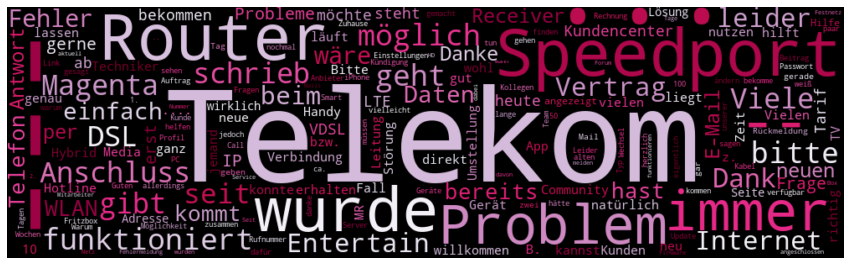

In [0]:
ta.wordcloud(stop_words=stop_words, savefig_file=None, background_color='black', colormap='PuRd', figsize = ((15,15)), width=1000, height=300)

## Testing ClassificationCorpusAnalysis

In [0]:
ca = ClassificationCorpusAnalysis(path=corpus_path_int/'data_nlu')

2019-11-13 19:03:07,580 Reading data from /gdrive/My Drive/embeddings-comparison/resources/corpora/classification_corpora/data_nlu
2019-11-13 19:03:07,581 Train: /gdrive/My Drive/embeddings-comparison/resources/corpora/classification_corpora/data_nlu/train.txt
2019-11-13 19:03:07,586 Dev: None
2019-11-13 19:03:07,588 Test: /gdrive/My Drive/embeddings-comparison/resources/corpora/classification_corpora/data_nlu/test.txt
Corpus: 1191 train + 132 dev + 148 test sentences


In [0]:
print(ca.obtain_statistics()[1])

{
    "dataset": "complete",
    "total_number_of_documents": 1471,
    "number_of_documents_per_class": {
        "asked_wohnsitz_form": 200,
        "said_hello": 45,
        "said_bye": 30,
        "asked_fahrzeug_form": 400,
        "asked_melde_form": 300,
        "asked_ausweis_form": 300,
        "asked_requirements": 30,
        "said_yes": 30,
        "said_was_misunderstood": 30,
        "asked_how_are_you": 30,
        "said_stop": 7,
        "said_no": 20,
        "asked_price": 24,
        "said_thanks": 25
    },
    "number_of_tokens_per_tag": {},
    "number_of_tokens": {
        "total": 7984,
        "min": 1,
        "max": 12,
        "avg": 5.427600271923861
    }
}


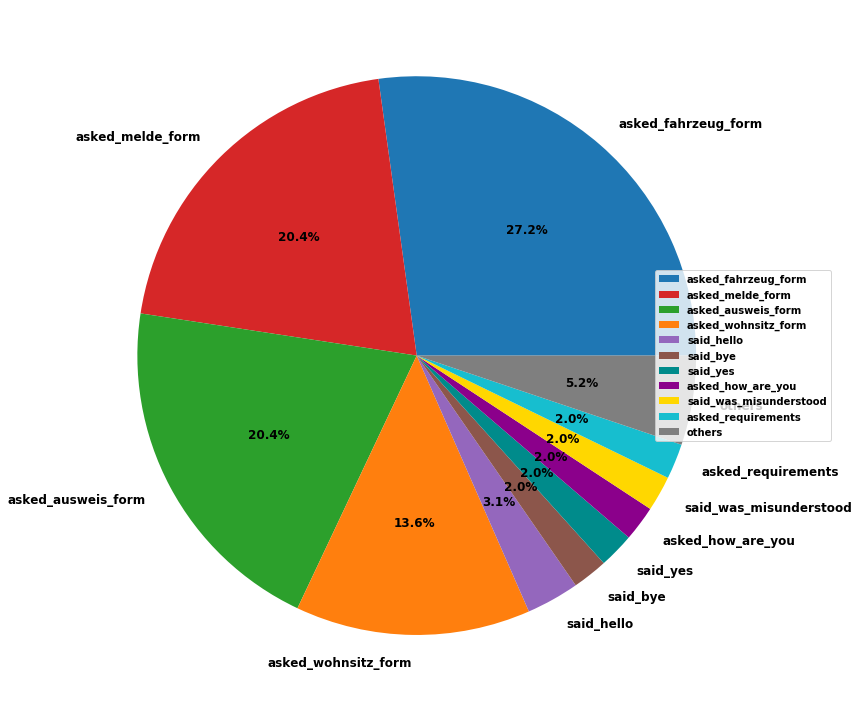

In [0]:
ca.class_distribution(multiclass=False, savefig_file='classes_bold.png', figsize=(13, 10),autopct='%1.1f%%', label='', fontsize=12, colors=['tab:blue','tab:red','tab:green','tab:orange','tab:purple','tab:brown','darkcyan','darkmagenta','gold','tab:cyan','tab:gray'])

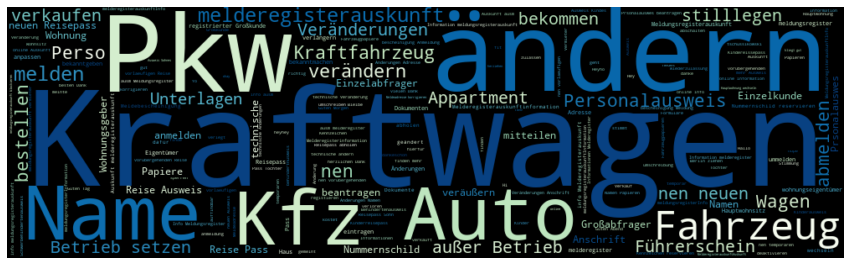

In [0]:
stop_words = stopwords.words('german') + ['möchte', 'hätte', 'gerne', 'bitte', 'ne', 'benötige', 'ja', 'nein', 'brauche', 'ikke']

ca.wordcloud( colormap='GnBu', figsize = ((15,15)), width=1000, height=300,  stopwords=stop_words) 

In [0]:
print(ca.most_common_tokens(stop_words=stop_words))

['nen', 'neuen', 'Reisepass', 'Ausweis', 'Pass', 'ändern', 'Kraftwagen', 'technische', 'Reise', 'Änderungen', 'Name', 'Veränderungen', 'Nummernschild', 'Namen', 'vorübergehenden']
